## 1.Data preprocess

###1.1 Data Load

In [211]:
import datetime as dt
from pathlib import Path
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("pastel")

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [212]:
data_path = Path('/content/drive/MyDrive/aiffel/yoochoose/data')
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [213]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

### 1.2 Session Length

__User_length__ 

In [214]:
# 사용자가 몇번의 액션을 취했는지(몇개의 평가를 했는지)
User_length = data.groupby('UserId').size()
User_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [215]:
print('median :', User_length.median())
print('mean   : {:.1f}'.format(User_length.mean()))
print('min    :', User_length.min())
print('max    :', User_length.max())

median : 96.0
mean   : 165.6
min    : 20
max    : 2314


* 사용자들은 평균적으로 165번의 평가를 함
* 가장 적은 평가를 한 사용자는 20번, 가장 많이 평가를 한 사용자는 2314번 평가를 함

In [216]:
# 가장 평가를 많이 한 사용자의 평가 내역 
many_rating = User_length[User_length==2314].index[0]
many_rating_user = data[data['UserId']==many_rating]
many_rating_user.head(5)

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392


Text(0.5, 1.0, 'UserID:4169')

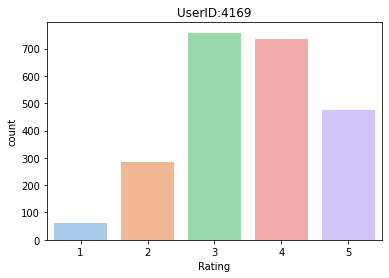

In [217]:
sns.countplot(many_rating_user['Rating'])
plt.title('UserID:4169')

* 가장 많은 평가를 남긴 `UserID : 4169`는 같은 시간에 많은 평가를 남긴 것을 확인함
* 영화를 보지 않아도 평가하는 것을 좋아하거나, 영화광으로 영화를 굉장히 많이 본 사람이 서비스를 이용을 시작하고 평가를 남긴 것으로 예상함
* 모든 영화에 같은 평점을 주지 않았으므로 남겨둠

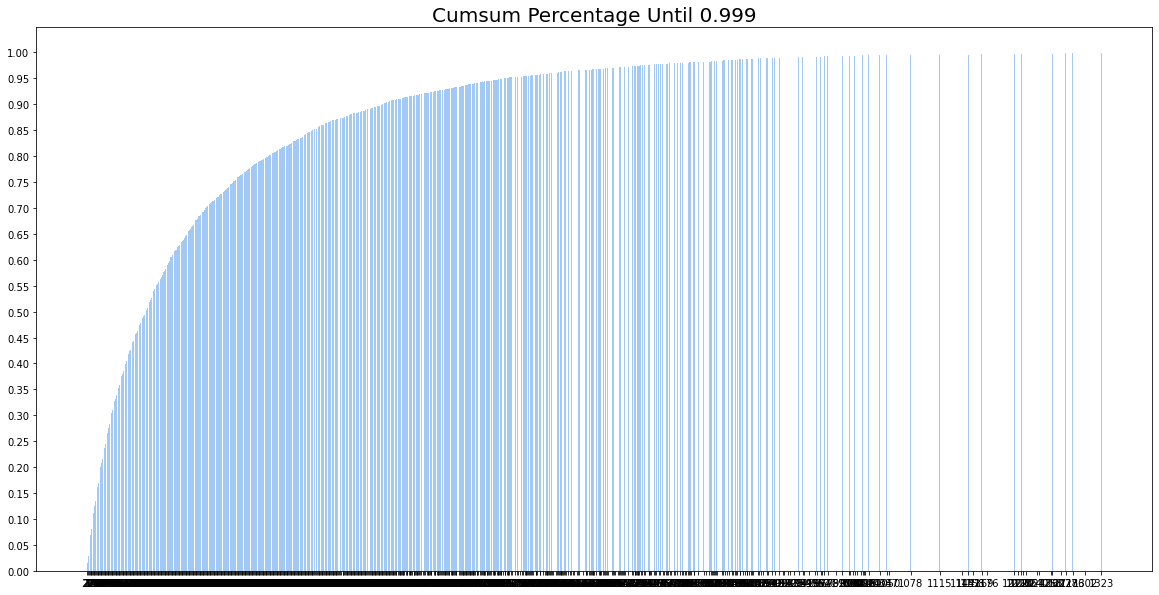

In [218]:
length_count = User_length.groupby(User_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999)
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### 1.3 Session Time

https://inma.tistory.com/96

In [219]:
from datetime import datetime
import time
timestamp = time.time()
print('timestamp :', timestamp)

today = datetime.fromtimestamp(timestamp)
print('datetime  :', today)

timestamp : 1630417021.5984845
datetime  : 2021-08-31 13:37:01.598485


In [220]:
from datetime import datetime

data['Time'] = data['Time'].map(lambda x: datetime.fromtimestamp(x))
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [221]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [222]:
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
data_month = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data_month

,UserId,ItemId,Rating,Time
28225,195,2808,3,2003-02-02 21:08:38
27759,195,1254,4,2003-02-06 17:23:42
27921,195,1456,2,2003-02-08 00:07:32
28443,195,468,3,2003-02-11 17:42:36
28255,195,2748,1,2003-02-11 18:23:28
...,...,...,...,...
984731,5950,3948,4,2003-02-27 18:13:57
984682,5950,3578,4,2003-02-27 18:14:30
984475,5950,3793,3,2003-02-27 18:15:10
984660,5950,3555,2,2003-02-27 18:15:37


* 1551개의 데이터는 학습을 시키기에 적은양으로 생각되어 2년치의 데이터 사용

In [223]:
month_ago = latest - dt.timedelta(760)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Rating,Time
2460,19,1215,5,2001-01-30 03:23:00
2475,19,111,4,2001-02-14 04:30:19
2391,19,32,4,2001-02-14 22:37:51
2395,19,2336,2,2001-02-14 22:42:10
2465,19,2888,2,2001-02-14 22:42:10
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


### 1.4 Data Cleansing

최소 1개 이상 평가했을 때, 다음 평가를 예측하는 것이 목표이므로 길이가 1인 세션 제거

In [224]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [225]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
2460,19,1215,5,2001-01-30 03:23:00
2475,19,111,4,2001-02-14 04:30:19
2391,19,32,4,2001-02-14 22:37:51
2395,19,2336,2,2001-02-14 22:42:10
2465,19,2888,2,2001-02-14 22:42:10
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


### 1.5 Train/ Valid/ Test split

2년치의 데이터를 사용했으니 test, val은 40일씩으로 잡음

In [226]:
print('min    :', data['Time'].min())
print('max    :', data['Time'].max())

min    : 2001-01-29 18:00:31
max    : 2003-02-28 17:49:50


In [227]:
test_time = data['Time'].max() - dt.timedelta(40)
test_time

Timestamp('2003-01-19 17:49:50')

In [228]:
valid_time = data['Time'].max() - dt.timedelta(80) 
valid_time

Timestamp('2002-12-10 17:49:50')

In [229]:
tr = data[data['Time'] <= valid_time]
tr

,UserId,ItemId,Rating,Time
2460,19,1215,5,2001-01-30 03:23:00
2475,19,111,4,2001-02-14 04:30:19
2391,19,32,4,2001-02-14 22:37:51
2395,19,2336,2,2001-02-14 22:42:10
2465,19,2888,2,2001-02-14 22:42:10
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [230]:
test = data[data['Time'] > test_time]
test

,UserId,ItemId,Rating,Time
13108,102,922,5,2003-01-29 00:08:01
13112,102,926,5,2003-01-29 00:08:01
13131,102,3099,5,2003-01-29 00:08:32
13098,102,2212,4,2003-01-29 00:09:12
13145,102,203,4,2003-01-29 00:11:54
...,...,...,...,...
984731,5950,3948,4,2003-02-27 18:13:57
984682,5950,3578,4,2003-02-27 18:14:30
984475,5950,3793,3,2003-02-27 18:15:10
984660,5950,3555,2,2003-02-27 18:15:37


In [231]:
val = data[(data['Time'] > valid_time) & (data['Time'] < test_time)]
val

,UserId,ItemId,Rating,Time
5200,36,2269,5,2002-12-22 08:05:50
5256,36,1701,4,2002-12-22 08:05:50
5184,36,2694,3,2002-12-22 08:08:14
5364,36,3786,4,2002-12-22 08:08:41
5262,36,2369,4,2002-12-22 08:09:24
...,...,...,...,...
984731,5950,3948,4,2003-02-27 18:13:57
984682,5950,3578,4,2003-02-27 18:14:30
984475,5950,3793,3,2003-02-27 18:15:10
984660,5950,3555,2,2003-02-27 18:15:37


In [232]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [233]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 72397
	 Sessions: 997
	 Items: 2549
	 First Time : 2001-01-29 18:00:31
	 Last Time : 2002-12-10 15:32:30

* valid Set Stats Info
	 Events: 3851
	 Sessions: 214
	 Items: 1629
	 First Time : 2002-12-10 21:39:27
	 Last Time : 2003-02-28 17:49:50

* test Set Stats Info
	 Events: 2048
	 Sessions: 128
	 Items: 1199
	 First Time : 2003-01-19 19:19:27
	 Last Time : 2003-02-28 17:49:50



In [234]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [235]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 2.Data Pipeline

### 2.1 Session Dataset
데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듦

In [236]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

`click_offsets` 변수는 각 세션이 시작된 인덱스를 담고 있고 `item_idx` 변수는 각 세션을 인덱싱한 `np.array`

In [237]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
2460,19,1215,5,2001-01-30 03:23:00,0
2475,19,111,4,2001-02-14 04:30:19,1
2391,19,32,4,2001-02-14 22:37:51,2
2395,19,2336,2,2001-02-14 22:42:10,3
2465,19,2888,2,2001-02-14 22:42:10,4
2371,19,1527,3,2001-02-14 22:42:43,5
2402,19,2918,4,2001-02-14 22:42:43,6
2423,19,2428,1,2001-02-14 22:42:43,7
2404,19,1974,3,2001-02-14 22:43:22,8
2484,19,3409,2,2001-02-14 22:43:22,9


In [238]:
tr_dataset.click_offsets

array([    0,    39,    50,    73,    98,   103,   164,   240,   323,
         353,   406,   443,   466,   475,   480,   491,   701,   977,
         979,  1065,  1158,  1174,  1206,  1221,  1232,  1300,  1318,
        1324,  1341,  1485,  1530,  1632,  1790,  1800,  2046,  2049,
        2078,  2114,  2120,  2138,  2157,  2200,  2554,  2571,  2647,
        2722,  2788,  2821,  2912,  3312,  3318,  3334,  3465,  3581,
        3590,  3654,  3661,  3786,  3860,  3925,  4011,  4048,  4055,
        4081,  4083,  4090,  4101,  4171,  4202,  4222,  4307,  4330,
        4415,  4440,  4725,  4738,  4742,  4784,  4943,  4945,  4985,
        5104,  5112,  5327,  5357,  5574,  5738,  5994,  6230,  6234,
        6289,  6294,  6326,  6329,  6348,  6350,  6356,  6395,  6408,
        6417,  6421,  6425,  6465,  6668,  6681,  6689,  6712,  7487,
        7674,  7682,  7787,  7814,  7928,  7970,  7989,  8067,  8083,
        8148,  8150,  8166,  8320,  8363,  8380,  8647,  8690,  8758,
        8830,  8845,

In [239]:
tr_dataset.session_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

### 2.2 Session Data Loader

In [240]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [241]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
2460,19,1215,5,2001-01-30 03:23:00,0
2475,19,111,4,2001-02-14 04:30:19,1
2391,19,32,4,2001-02-14 22:37:51,2
2395,19,2336,2,2001-02-14 22:42:10,3
2465,19,2888,2,2001-02-14 22:42:10,4
2371,19,1527,3,2001-02-14 22:42:43,5
2402,19,2918,4,2001-02-14 22:42:43,6
2423,19,2428,1,2001-02-14 22:42:43,7
2404,19,1974,3,2001-02-14 22:43:22,8
2484,19,3409,2,2001-02-14 22:43:22,9


In [242]:
iter_ex = iter(tr_data_loader)

In [243]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 39 48 70]
Label Item Idx are :       [ 1 40 49 71]
Previous Masked Input Idx are []


## 3.Modeling

### 3.1 Evaluation Metric

In [244]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 3.2 Model Architecture

In [245]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [246]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [247]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=56, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [248]:
model = create_model(args)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(56, 1, 2549)]           0         
_________________________________________________________________
GRU (GRU)                    [(56, 50), (56, 50)]      390150    
_________________________________________________________________
dropout_7 (Dropout)          (56, 50)                  0         
_________________________________________________________________
dense_7 (Dense)              (56, 2549)                129999    
Total params: 520,149
Trainable params: 520,149
Non-trainable params: 0
_________________________________________________________________


### 3.3 Model Training

In [249]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [250]:
train_model(model, args)

Evaluation:  39%|███▉      | 25/64 [00:09<00:14,  2.75it/s]


	 - Recall@20 epoch 1: 0.044286
	 - MRR@20    epoch 1: 0.009522



Evaluation:  39%|███▉      | 25/64 [00:08<00:13,  2.97it/s]


	 - Recall@20 epoch 2: 0.048571
	 - MRR@20    epoch 2: 0.011953



Evaluation:  39%|███▉      | 25/64 [00:08<00:12,  3.02it/s]

	 - Recall@20 epoch 3: 0.058571
	 - MRR@20    epoch 3: 0.016207



In [251]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 5)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  18%|█▊        | 6/34 [00:01<00:04,  5.65it/s]

	 - Recall@20: 0.038690
	 - MRR@20: 0.018700



## Condition 1. Increase Data

전체 데이터로 진행



In [281]:
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.

data['Time'] = data['Time'].map(lambda x: datetime.fromtimestamp(x))

data = cleanse_recursive(data, shortest=2, least_click=5)

In [282]:
test_time = data['Time'].max() - dt.timedelta(120)
valid_time = data['Time'].max() - dt.timedelta(240) 

In [283]:
tr = data[data['Time'] <= valid_time]
test = data[data['Time'] > test_time]
val = data[(data['Time'] > valid_time) & (data['Time'] < test_time)]

In [284]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 986992
	 Sessions: 6039
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-07-03 17:31:04

* valid Set Stats Info
	 Events: 6106
	 Sessions: 278
	 Items: 2078
	 First Time : 2002-07-03 23:06:51
	 Last Time : 2002-10-31 16:33:08

* test Set Stats Info
	 Events: 6513
	 Sessions: 277
	 Items: 2069
	 First Time : 2002-10-31 19:58:49
	 Last Time : 2003-02-28 17:49:50



In [285]:
tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [286]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [287]:
tr_dataset = SessionDataset(tr)
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
iter_ex = iter(tr_data_loader)
inputs, labels, mask =  next(iter_ex)

In [291]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [292]:
model = create_model(args)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(128, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    520200    
_________________________________________________________________
dropout_15 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_15 (Dense)             (128, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


In [293]:
train_model(model, args)

Evaluation:  27%|██▋       | 12/45 [00:08<00:24,  1.36it/s]


	 - Recall@20 epoch 1: 0.065755
	 - MRR@20    epoch 1: 0.012670



Evaluation:  27%|██▋       | 12/45 [00:08<00:23,  1.40it/s]


	 - Recall@20 epoch 2: 0.081380
	 - MRR@20    epoch 2: 0.017656



Evaluation:  27%|██▋       | 12/45 [00:08<00:22,  1.44it/s]

	 - Recall@20 epoch 3: 0.084635
	 - MRR@20    epoch 3: 0.020674



In [294]:
test_model(model, args, test)

Evaluation:  25%|██▌       | 12/48 [00:04<00:12,  2.97it/s]

	 - Recall@20: 0.057943
	 - MRR@20: 0.029112



## Condition 2. Learning Rate

In [253]:
args1 = Args(tr, val, test, batch_size=56, hsz=50, drop_rate=0.1, lr=0.0001, epochs=3, k=20)
model1 = create_model(args1)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(56, 1, 2549)]           0         
_________________________________________________________________
GRU (GRU)                    [(56, 50), (56, 50)]      390150    
_________________________________________________________________
dropout_9 (Dropout)          (56, 50)                  0         
_________________________________________________________________
dense_9 (Dense)              (56, 2549)                129999    
Total params: 520,149
Trainable params: 520,149
Non-trainable params: 0
_________________________________________________________________


In [255]:
train_model(model1, args)

Evaluation:  39%|███▉      | 25/64 [00:08<00:13,  2.88it/s]


	 - Recall@20 epoch 1: 0.049286
	 - MRR@20    epoch 1: 0.009646



Evaluation:  39%|███▉      | 25/64 [00:08<00:13,  2.97it/s]


	 - Recall@20 epoch 2: 0.047857
	 - MRR@20    epoch 2: 0.009494



Evaluation:  39%|███▉      | 25/64 [00:08<00:13,  2.92it/s]

	 - Recall@20 epoch 3: 0.047857
	 - MRR@20    epoch 3: 0.009394



In [256]:
test_model(model1, args, test)

Evaluation:  18%|█▊        | 6/34 [00:01<00:04,  5.97it/s]

	 - Recall@20: 0.032738
	 - MRR@20: 0.010367



## Condition 3. Hsz

In [258]:
args2 = Args(tr, val, test, batch_size=56, hsz=70, drop_rate=0.1, lr=0.0001, epochs=3, k=20)
model2 = create_model(args2)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(56, 1, 2549)]           0         
_________________________________________________________________
GRU (GRU)                    [(56, 70), (56, 70)]      550410    
_________________________________________________________________
dropout_11 (Dropout)         (56, 70)                  0         
_________________________________________________________________
dense_11 (Dense)             (56, 2549)                180979    
Total params: 731,389
Trainable params: 731,389
Non-trainable params: 0
_________________________________________________________________


In [260]:
train_model(model2, args2)

Evaluation:  39%|███▉      | 25/64 [00:08<00:13,  2.93it/s]


	 - Recall@20 epoch 1: 0.043571
	 - MRR@20    epoch 1: 0.009407



Evaluation:  39%|███▉      | 25/64 [00:08<00:13,  2.88it/s]


	 - Recall@20 epoch 2: 0.049286
	 - MRR@20    epoch 2: 0.009447



Evaluation:  39%|███▉      | 25/64 [00:08<00:13,  2.96it/s]

	 - Recall@20 epoch 3: 0.049286
	 - MRR@20    epoch 3: 0.009216



In [261]:
test_model(model2, args, test)

Evaluation:  18%|█▊        | 6/34 [00:00<00:04,  6.59it/s]

	 - Recall@20: 0.029762
	 - MRR@20: 0.009028



recall의 개념을 확장한 `recall@k` 지표, `precision`의 개념을 확장한 `Mean Average Precision@k` 지표 등을 사용함

__Base Model__ : 2년치의 데이터 + `args = Args(tr, val, test, batch_size=56, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)`

- Recall@20 : 0.038690
- MRR@20 : 0.018700

__Model 1__ : 전체 데이터 + `args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)`

- Recall@20: 0.057943
- MRR@20: 0.029112

__Model 2__ : 2년치의 데이터 + `args = Args(tr, val, test, batch_size=56, hsz=50, drop_rate=0.1, lr=0.0001, epochs=3, k=20)`
- Recall@20: 0.032738
- MRR@20: 0.010367

__Model 3__ : 2년치의 데이터 + `args = Args(tr, val, test, batch_size=56, hsz=70, drop_rate=0.1, lr=0.0001, epochs=3, k=20)`
- Recall@20: 0.029762
- MRR@20: 0.009028


## 회고 

전체 데이터로 돌린 첫 모델이 가장 좋은 성능을 보였다. 2년치의 데이터만 가져왔을 때 보다 시간은 더 걸렸지만 성능은 더 좋았다. 

세션정의에 대한 이해가 어려웠고 데이터 사이즈, 모델구조와 하이퍼파라미터들을 변경해서 여러 모델들을 만들었다. 

어려웠던 점은 날짜 변경과 모델이 돌아가지 않아서인데, 이 부분은 다른 분들의 도움으로 batch_size를 변경해 해결하였다. 

하지만 예상한 성능보다 좋지 못해 아쉬운 익스다. 개인적인 사정으로 많은 시간을 투자하지 못했는데, 다음엔 더 애정을 갖고 많은 시간을 투자해서 만족할 수 있는 모델을 만들어봐야겠다. 